# Boston Crime Incident Reports — EDA & Bias Analysis

**Dataset:** [Crime Incident Reports (Aug 2015 – present)](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system)  
**Resource ID:** `b973d8cb-eeb2-4e7e-99da-c92938efc9c0`

This notebook covers:
1. Data ingestion via the CKAN DataStore API
2. Exploratory Data Analysis (EDA)
3. Data Slicing for Bias Detection
4. Bias Mitigation
5. Documentation of findings

---
## 0 · Imports & Configuration

In [6]:
import warnings
warnings.filterwarnings("ignore")

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Fairlearn for multi-slice metric comparison
try:
    from fairlearn.metrics import MetricFrame, count
    HAS_FAIRLEARN = True
except ImportError:
    HAS_FAIRLEARN = False
    print("Fairlearn not installed – run: pip install fairlearn")

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

RESOURCE_ID = "b973d8cb-eeb2-4e7e-99da-c92938efc9c0"
BASE_URL    = "https://data.boston.gov/api/3/action/datastore_search"
BATCH_SIZE  = 10_000

print("Ready.")

Ready.


---
## 1 · Data Ingestion

In [8]:
def fetch_all_records(resource_id: str, batch_size: int = 10_000) -> pd.DataFrame:
    """Paginate through CKAN DataStore and return all records as a DataFrame."""
    all_records, offset = [], 0
    params = {"resource_id": resource_id, "limit": batch_size, "offset": 0}

    resp = requests.get(BASE_URL, params=params, timeout=60)
    resp.raise_for_status()
    data = resp.json()
    if not data.get("success"):
        raise RuntimeError(f"API error: {data.get('error')}")

    result = data["result"]
    total  = result["total"]
    print(f"Total records: {total:,}")
    all_records.extend(result["records"])
    offset += batch_size

    while offset < total:
        params["offset"] = offset
        batch = requests.get(BASE_URL, params=params, timeout=60).json()["result"]["records"]
        all_records.extend(batch)
        offset += batch_size
        print(f"  {min(offset, total):,}/{total:,}", end="\r")

    print(f"\nLoaded {len(all_records):,} records.")
    return pd.DataFrame(all_records)


df_raw = fetch_all_records(RESOURCE_ID, BATCH_SIZE)
df_raw.head(5)

Total records: 247,834
  247,834/247,834
Loaded 247,834 records.


,_id,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,1,232007173,3115,None,INVESTIGATE PERSON,B3,,0,2023-01-27 22:44:00+00,2023,1,Friday,22,None,FAVRE ST,42.27166144598919,-71.09953381947697,"(42.27166144598919, -71.09953381947697)"
1,2,242068697,3410,None,TOWED MOTOR VEHICLE,C6,186,0,2024-08-14 00:00:00+00,2024,8,Wednesday,0,None,JAN KARSKI WAY,None,None,None
2,3,252095371,1402,None,VANDALISM,A1,77,0,2025-11-09 20:00:00+00,2025,11,Sunday,20,None,SUDBURY ST,None,None,None
3,4,242081942,1831,None,SICK ASSIST,A15,49,0,2024-09-25 14:09:00+00,2024,9,Wednesday,14,None,ALFORD STREET,None,None,None
4,5,252022654,3207,None,PROPERTY - FOUND,A1,77,0,2025-03-22 16:31:00+00,2025,3,Saturday,16,None,SUDBURY ST,None,None,None


In [ ]:
# ── Type coercions ────────────────────────────────────────────────────────────
df = df_raw.copy()

if "OCCURRED_ON_DATE" in df.columns:
    df["OCCURRED_ON_DATE"] = pd.to_datetime(df["OCCURRED_ON_DATE"], errors="coerce")

for col in ["Lat", "Long", "YEAR", "MONTH", "HOUR"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop placeholder coordinates (0,0)
if {"Lat", "Long"}.issubset(df.columns):
    df.loc[(df["Lat"] == 0) | (df["Long"] == 0), ["Lat", "Long"]] = np.nan

# Derived features
if "OCCURRED_ON_DATE" in df.columns:
    df["DAY_OF_WEEK"] = df["OCCURRED_ON_DATE"].dt.day_name()
    df["DATE"]        = df["OCCURRED_ON_DATE"].dt.date

if "HOUR" in df.columns:
    bins   = [0, 6, 12, 18, 24]
    labels = ["Night (0-5)", "Morning (6-11)", "Afternoon (12-17)", "Evening (18-23)"]
    df["TIME_OF_DAY"] = pd.cut(df["HOUR"], bins=bins, labels=labels, right=False, include_lowest=True)

print("Shape:", df.shape)
df.dtypes

---
## 2 · Exploratory Data Analysis

### 2.1 Dataset Overview

In [11]:
print("=" * 60)
print(f"Rows  : {df.shape[0]:,}")
print(f"Cols  : {df.shape[1]}")
print("=" * 60)

missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
overview = pd.DataFrame({"Missing": missing, "Missing %": missing_pct})
overview = overview[overview["Missing"] > 0].sort_values("Missing %", ascending=False)
print("\nColumns with missing values:")
display(overview)

Rows  : 247,834
Cols  : 18

Columns with missing values:


,Missing,Missing %
OFFENSE_CODE_GROUP,247834,100.00
UCR_PART,247834,100.00
REPORTING_AREA,30601,12.35
Lat,14777,5.96
Long,14777,5.96
Location,14777,5.96
DISTRICT,484,0.20


### 2.2 Univariate Distributions

 Unique Districts: 14
  ['A1', 'A15', 'A7', 'B2', 'B3', 'C11', 'C6', 'D14', 'D4', 'E13', 'E18', 'E5', 'External', 'Outside of']

 Incidents by Day of Week:
   Monday        36,141
   Tuesday       36,319
   Wednesday     36,571
   Thursday      36,094
   Friday        37,951
   Saturday      33,887
   Sunday        30,871

 Shooting Incidents:
   No Shooting (0): 246,130
   Shooting    (1):   1,704
   Shooting Rate  : 0.69%



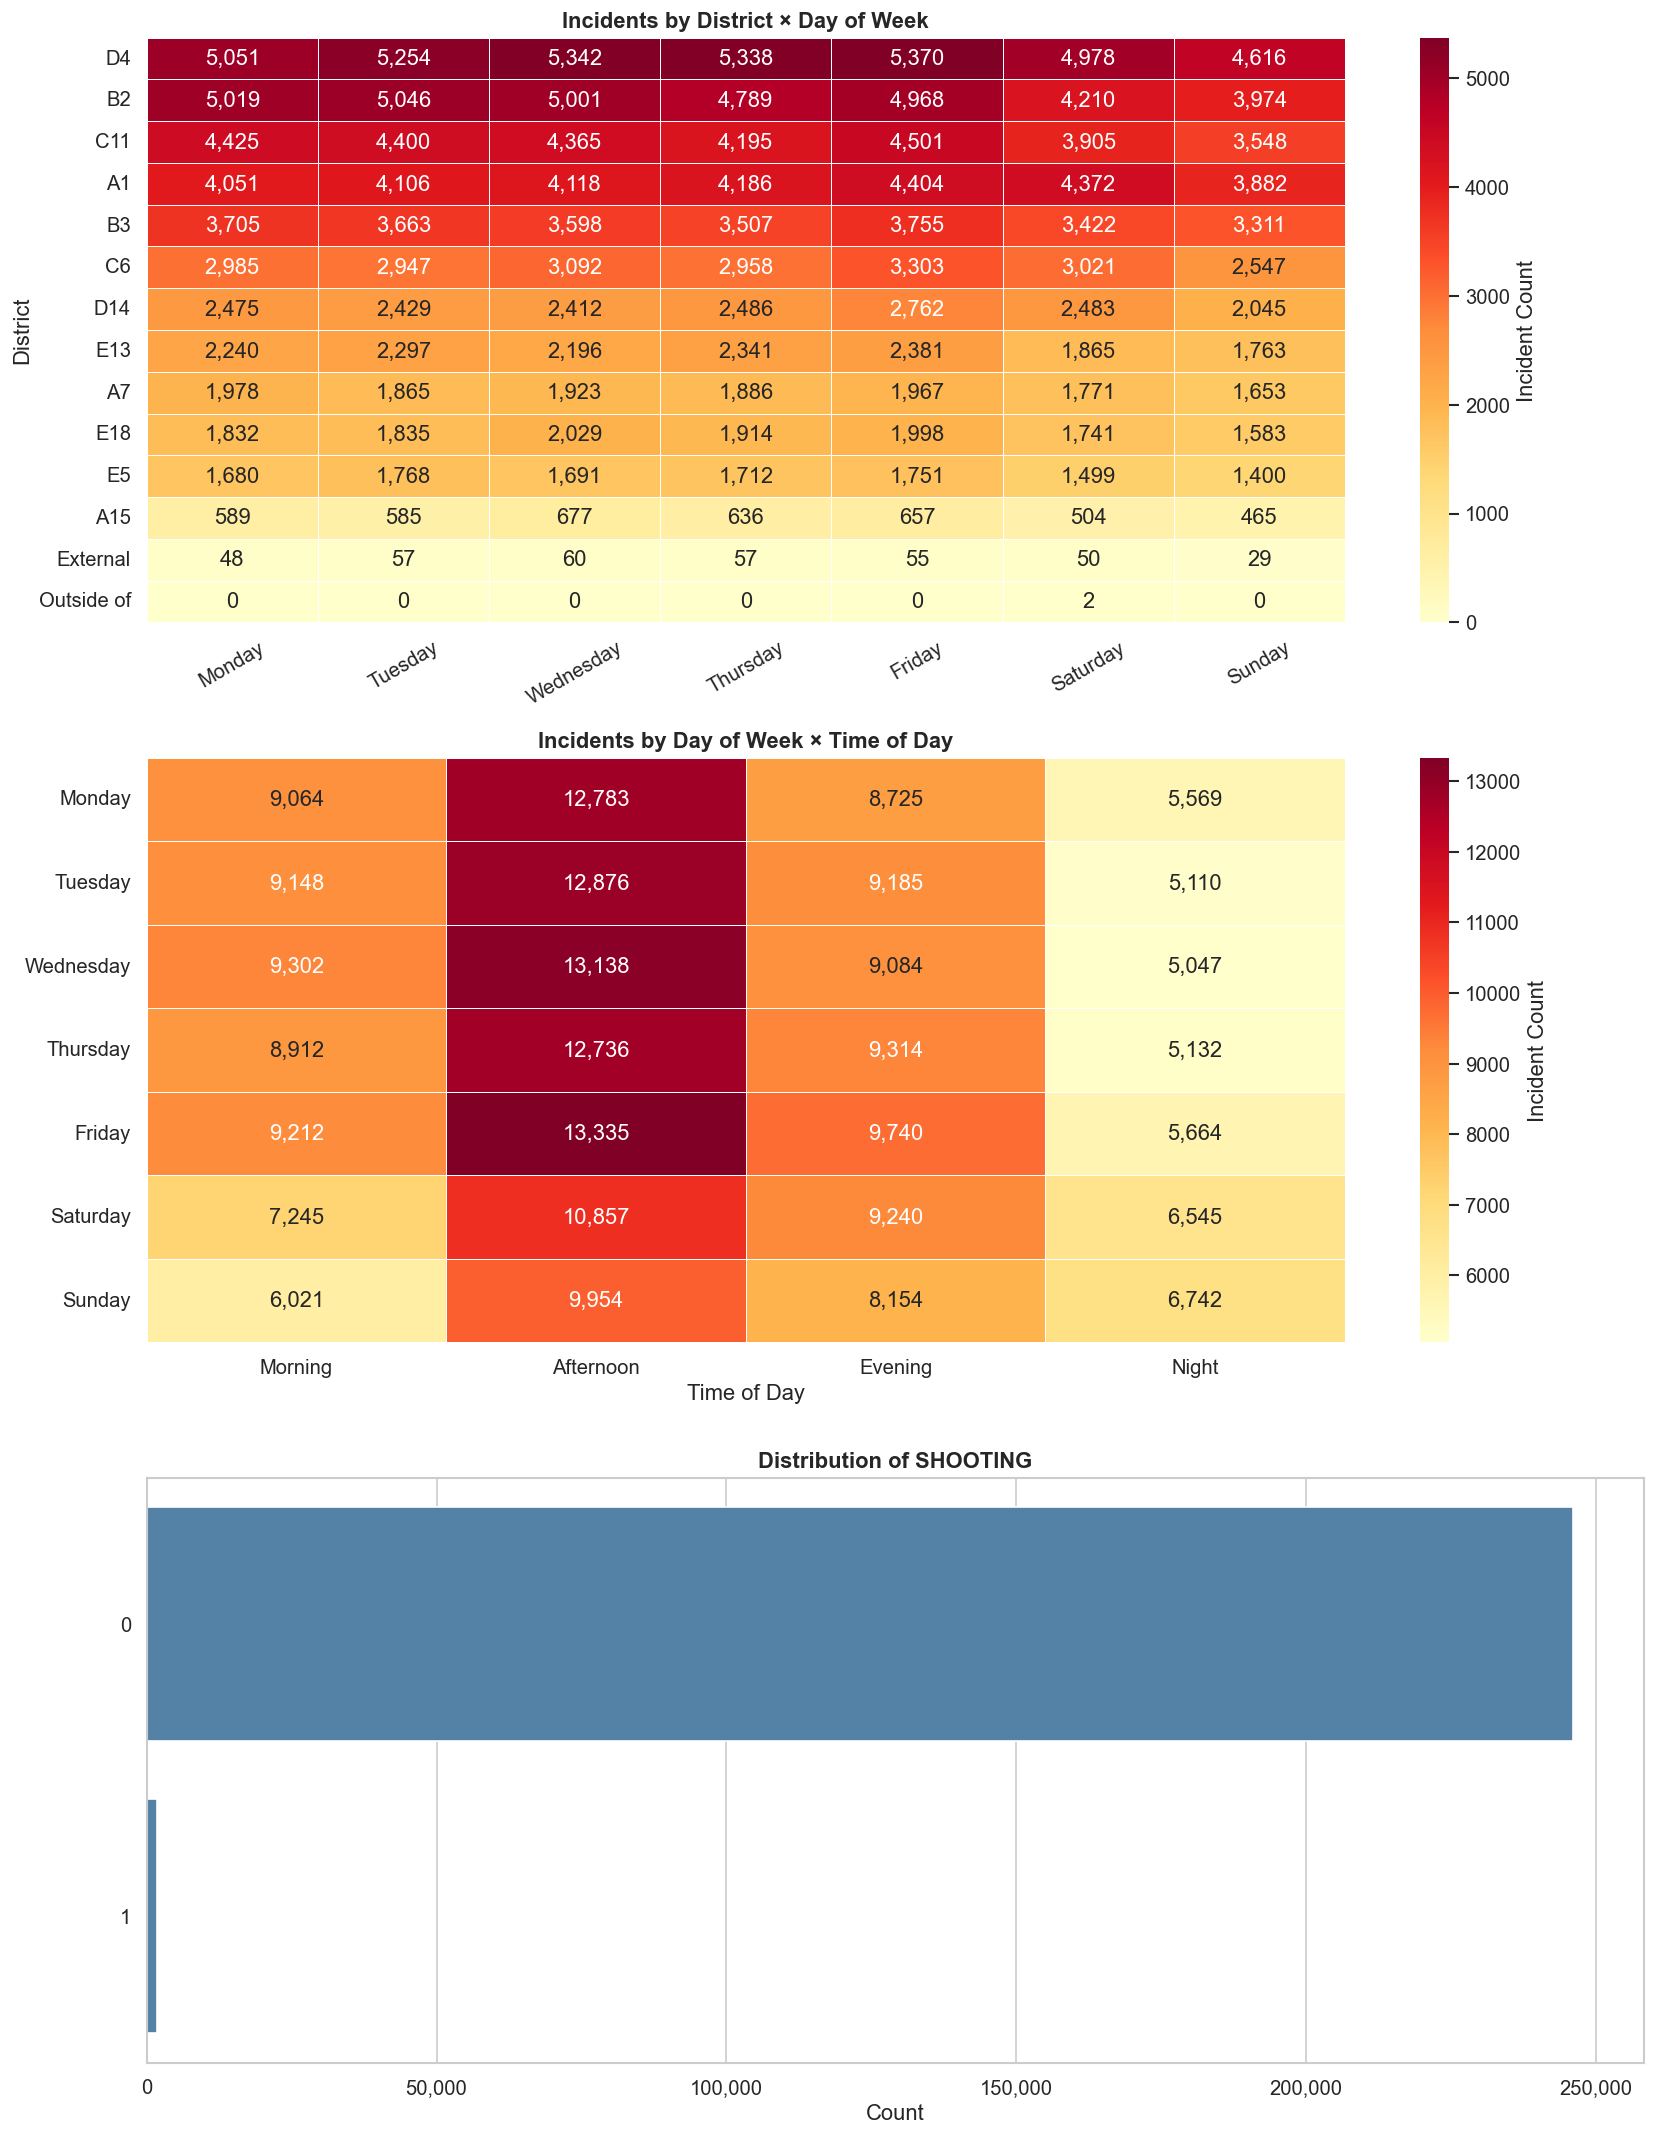

In [ ]:
cat_cols = [c for c in ["DISTRICT", "DAY_OF_WEEK", "SHOOTING"] if c in df.columns]

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Normalize DAY_OF_WEEK to match day_order exactly
if "DAY_OF_WEEK" in df.columns:
    df["DAY_OF_WEEK"] = df["DAY_OF_WEEK"].astype(str).str.strip().str.title()

# Bin HOUR into time-of-day periods
time_order = ["Morning", "Afternoon", "Evening", "Night"]
if "HOUR" in df.columns:
    df["TIME_OF_DAY"] = pd.cut(
        df["HOUR"],
        bins=[-1, 5, 11, 17, 23],
        labels=["Night", "Morning", "Afternoon", "Evening"]
    )

print("=" * 50)

if "DISTRICT" in df.columns:
    unique_districts = df["DISTRICT"].nunique()
    print(f" Unique Districts: {unique_districts}")
    print(f"  {sorted(df['DISTRICT'].dropna().unique().tolist())}\n")

if "DAY_OF_WEEK" in df.columns:
    print(" Incidents by Day of Week:")
    dow_counts = df["DAY_OF_WEEK"].value_counts().reindex(day_order)
    for day, count in dow_counts.items():
        print(f"   {day:<12} {count:>7,}")
    print()

if "SHOOTING" in df.columns:
    shooting_counts = df["SHOOTING"].value_counts().sort_index()
    print(" Shooting Incidents:")
    print(f"   No Shooting (0): {shooting_counts.get(0, 0):>7,}")
    print(f"   Shooting    (1): {shooting_counts.get(1, 0):>7,}")
    total = shooting_counts.sum()
    pct = (shooting_counts.get(1, 0) / total) * 100
    print(f"   Shooting Rate  : {pct:.2f}%")

print("=" * 50 + "\n")

fig, axes = plt.subplots(len(cat_cols), 1, figsize=(14, 6 * len(cat_cols)))
if len(cat_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, cat_cols):
    if col == "DISTRICT":
        # Pivot: districts as rows, days as columns
        pivot = (
            df.groupby(["DISTRICT", "DAY_OF_WEEK"])
            .size()
            .unstack(fill_value=0)
            .reindex(columns=day_order)
        )
        # Sort districts by total incident count (busiest at top)
        pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

        sns.heatmap(
            pivot,
            ax=ax,
            cmap="YlOrRd",
            fmt=",d",
            annot=True,
            linewidths=0.5,
            cbar_kws={"label": "Incident Count"},
        )
        ax.set_title("Incidents by District × Day of Week", fontweight="bold")
        ax.set_xlabel("")
        ax.set_ylabel("District")
        ax.tick_params(axis="x", rotation=30)
        ax.tick_params(axis="y", rotation=0)

    elif col == "DAY_OF_WEEK":
        # Pivot: day of week as rows, time of day as columns
        pivot = (
            df.groupby(["DAY_OF_WEEK", "TIME_OF_DAY"])
            .size()
            .unstack(fill_value=0)
            .reindex(index=day_order, columns=time_order)
        )
        sns.heatmap(
            pivot,
            ax=ax,
            cmap="YlOrRd",
            fmt=",d",
            annot=True,
            linewidths=0.5,
            cbar_kws={"label": "Incident Count"},
        )
        ax.set_title("Incidents by Day of Week × Time of Day", fontweight="bold")
        ax.set_xlabel("Time of Day")
        ax.set_ylabel("")
        ax.tick_params(axis="x", rotation=0)
        ax.tick_params(axis="y", rotation=0)

    else:
        vc = df[col].value_counts().head(20)
        sns.barplot(x=vc.values, y=vc.index, ax=ax, orient="h", color="steelblue")
        ax.set_title(f"Distribution of {col}", fontweight="bold")
        ax.set_xlabel("Count")
        ax.set_ylabel("")
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.tight_layout()
plt.show()

### 2.3 Temporal Trends

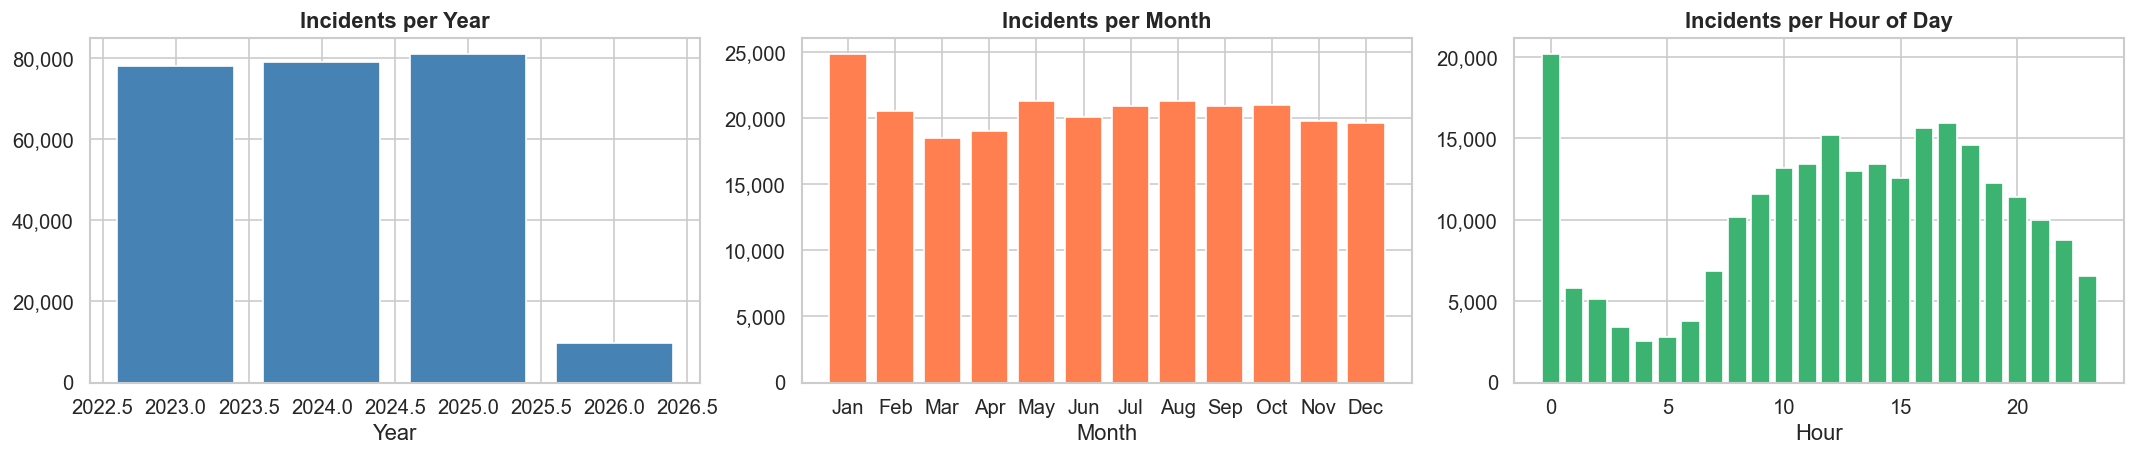

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Crimes per year
if "YEAR" in df.columns:
    yr = df["YEAR"].value_counts().sort_index()
    axes[0].bar(yr.index.astype(int), yr.values, color="steelblue", edgecolor="white")
    axes[0].set_title("Incidents per Year", fontweight="bold")
    axes[0].set_xlabel("Year")
    axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

# Crimes per month
if "MONTH" in df.columns:
    mo = df["MONTH"].value_counts().sort_index()
    month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    axes[1].bar([month_labels[int(m)-1] for m in mo.index], mo.values, color="coral", edgecolor="white")
    axes[1].set_title("Incidents per Month", fontweight="bold")
    axes[1].set_xlabel("Month")
    axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

# Crimes per hour
if "HOUR" in df.columns:
    hr = df["HOUR"].value_counts().sort_index()
    axes[2].bar(hr.index.astype(int), hr.values, color="mediumseagreen", edgecolor="white")
    axes[2].set_title("Incidents per Hour of Day", fontweight="bold")
    axes[2].set_xlabel("Hour")
    axes[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.tight_layout()
plt.show()

### 2.4 Geographic Distribution

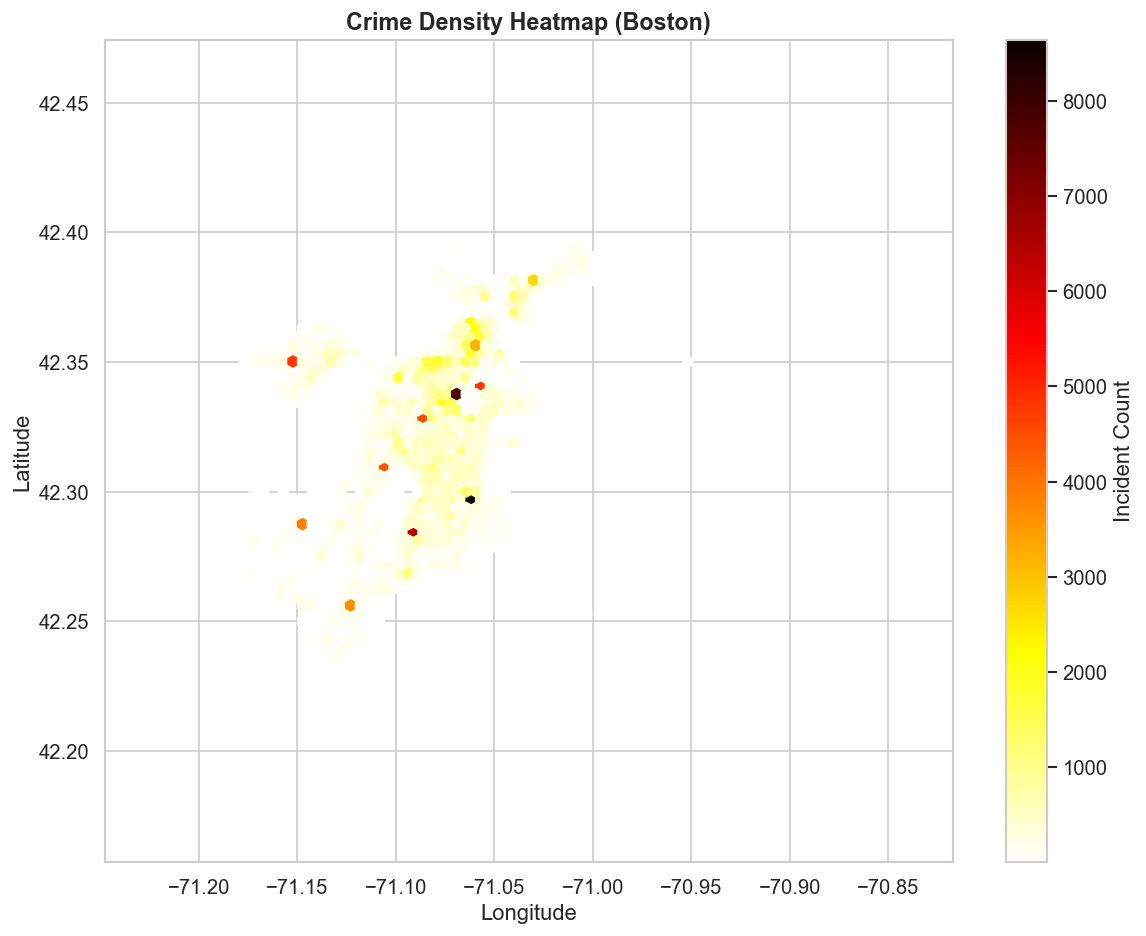

In [24]:
geo = df.dropna(subset=["Lat", "Long"])

if len(geo) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.hexbin(
        geo["Long"], geo["Lat"],
        gridsize=80, cmap="hot_r", mincnt=1
    )
    ax.set_title("Crime Density Heatmap (Boston)", fontweight="bold", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    cb = plt.colorbar(ax.collections[0], ax=ax)
    cb.set_label("Incident Count")
    plt.tight_layout()
    plt.show()
else:
    print("No valid geographic coordinates found.")

---
## 3 · Data Slicing for Bias Detection

Because crime data does not carry direct demographic attributes (age, gender) at the incident level, we use **structural proxies** as slicing dimensions:

| Dimension | Column | Rationale |
|---|---|---|
| Geographic | `DISTRICT` | Different policing intensity by area |
| Crime severity | `UCR_PART` | Part 1 (serious) vs Part 2/3 |
| Offense category | `OFFENSE_CODE_GROUP` | Distribution across crime types |
| Time of day | `TIME_OF_DAY` | Over/under-reporting by shift |
| Shooting involvement | `SHOOTING` | Violent crime flag |

> **Representational bias** can manifest as certain districts or time windows having disproportionately many/few records — indicating selective reporting, uneven patrol coverage, or data-collection gaps.

In [27]:
# Slicing dimensions available in the dataset
SLICE_DIMS = [c for c in [ "UCR_PART", "OFFENSE_CODE_GROUP"] if c in df.columns]
print("Active slice dimensions:", SLICE_DIMS)

Active slice dimensions: ['UCR_PART', 'OFFENSE_CODE_GROUP']


### 3.1 Slice-level Record Counts & Share

In [30]:
def slice_summary(df: pd.DataFrame, col: str, top_n: int = 20) -> pd.DataFrame:
    """Return count, share, and missing-value rate per slice."""
    vc  = df[col].value_counts(dropna=False).head(top_n).rename("count")
    pct = (vc / len(df) * 100).rename("share_%").round(2)

    # Fill NaN slice label so groupby can key on it safely
    temp_col = "__slice__"
    df[temp_col] = df[col].astype(str).fillna("NaN")          
    key_map   = df[col].astype(str).fillna("NaN")             

    miss = (
        df.groupby(temp_col)
          .apply(lambda g: g.drop(columns=temp_col).isnull().mean().mean() * 100)
          .rename("avg_missing_%")
          .round(2)
    )
    df.drop(columns=temp_col, inplace=True)

    # Align miss index to vc index (both now string-keyed)
    vc.index   = vc.index.astype(str).fillna("NaN")
    pct.index  = pct.index.astype(str).fillna("NaN")

    summary = pd.concat([vc, pct, miss], axis=1).reindex(vc.index)  # reindex instead of .loc
    return summary


for dim in ["DISTRICT", "UCR_PART", "TIME_OF_DAY"]:
    if dim in df.columns:
        print(f"\n── Slice: {dim} ─────────────────────────")
        display(slice_summary(df, dim))


── Slice: DISTRICT ─────────────────────────


,count,share_%,avg_missing_%
DISTRICT,,,
D4,35949,14.51,11.66
B2,33007,13.32,11.90
C11,29339,11.84,11.63
A1,29119,11.75,13.94
B3,24961,10.07,11.84
C6,20853,8.41,12.34
D14,17092,6.90,11.58
E13,15083,6.09,11.72
A7,13043,5.26,12.04



── Slice: UCR_PART ─────────────────────────


,count,share_%,avg_missing_%
UCR_PART,,,
None,247834,100.0,12.13



── Slice: TIME_OF_DAY ─────────────────────────


,count,share_%,avg_missing_%
TIME_OF_DAY,,,
Afternoon,85679,34.57,12.10
Evening,63442,25.60,12.08
Morning,58904,23.77,12.15
Night,39809,16.06,12.23


### 3.2 Visualising Slice Imbalance

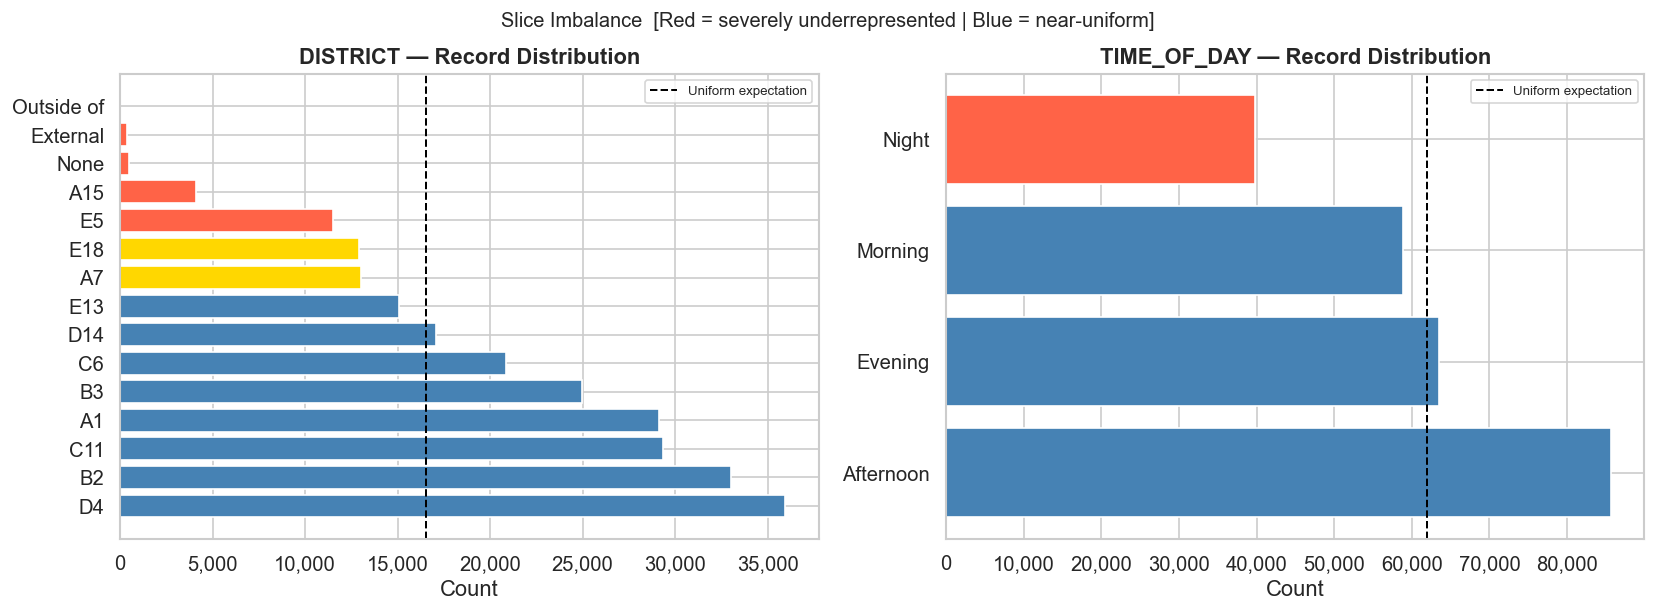

In [32]:
plot_dims = [c for c in ["DISTRICT", "TIME_OF_DAY"] if c in df.columns]
fig, axes = plt.subplots(1, len(plot_dims), figsize=(7 * len(plot_dims), 5))
if len(plot_dims) == 1:
    axes = [axes]

for ax, dim in zip(axes, plot_dims):
    vc = df[dim].value_counts(dropna=False)
    expected = len(df) / len(vc)  # uniform expectation
    colors = ["tomato" if v < expected * 0.7 else
               "gold" if v < expected * 0.9 else
               "steelblue" for v in vc.values]
    ax.barh(vc.index.astype(str), vc.values, color=colors)
    ax.axvline(expected, color="black", linestyle="--", linewidth=1.2, label="Uniform expectation")
    ax.set_title(f"{dim} — Record Distribution", fontweight="bold")
    ax.set_xlabel("Count")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle("Slice Imbalance  [Red = severely underrepresented | Blue = near-uniform]",
             y=1.02, fontsize=12)
plt.show()

### 3.3 Slice-level Missing-Value Rate (Reporting Bias Proxy)

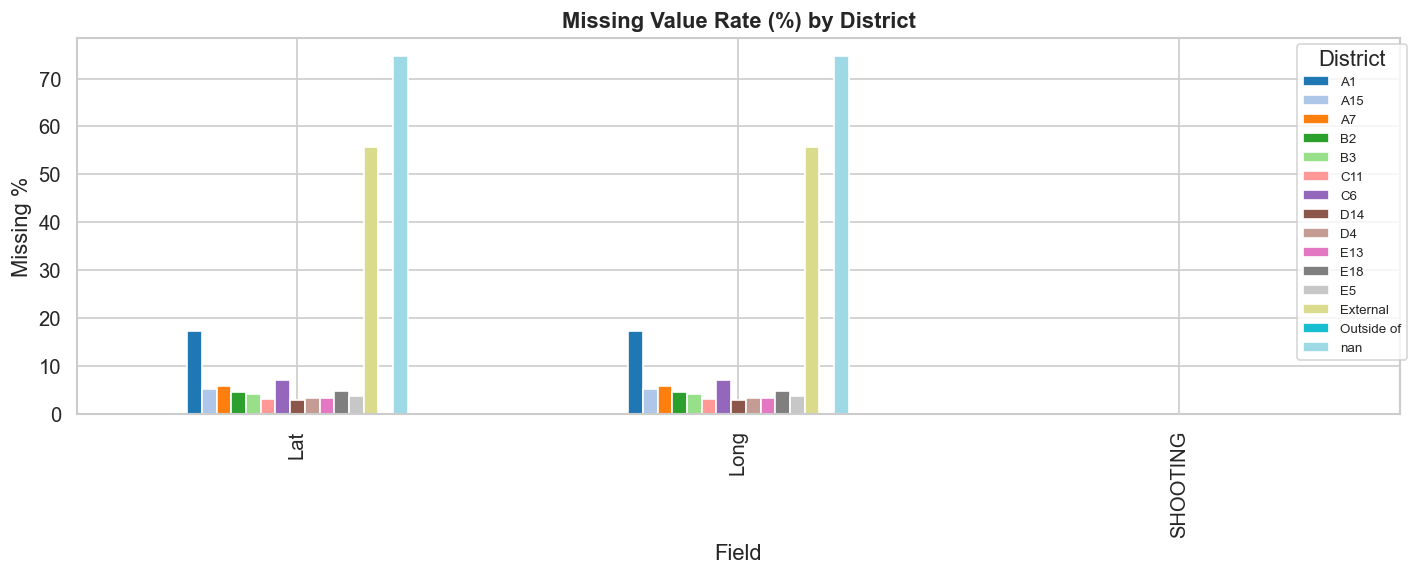

,Lat,Long,SHOOTING
DISTRICT,,,
A1,17.25,17.25,0.0
A15,5.28,5.28,0.0
A7,5.87,5.87,0.0
B2,4.54,4.54,0.0
B3,4.27,4.27,0.0
C11,3.12,3.12,0.0
C6,7.10,7.10,0.0
D14,2.93,2.93,0.0
D4,3.34,3.34,0.0


In [34]:
if "DISTRICT" in df.columns:
    key_cols = [c for c in ["Lat", "Long", "SHOOTING"] if c in df.columns]
    miss_by_district = (
        df.groupby("DISTRICT", dropna=False)[key_cols]
          .apply(lambda g: g.isnull().mean() * 100)
          .round(2)
    )

    fig, ax = plt.subplots(figsize=(12, 5))
    miss_by_district.T.plot(kind="bar", ax=ax, colormap="tab20", edgecolor="white")
    ax.set_title("Missing Value Rate (%) by District", fontweight="bold")
    ax.set_ylabel("Missing %")
    ax.set_xlabel("Field")
    ax.legend(title="District", bbox_to_anchor=(1.01, 1), fontsize=8)
    plt.tight_layout()
    plt.show()

    display(miss_by_district)

---
## 4 · Bias Mitigation

After detecting imbalances we apply **two complementary strategies**:

| Strategy | Technique | Applied to |
|---|---|---|
| **Re-sampling** | Oversample underrepresented districts to the median district size | `DISTRICT` slice |
| **Decision-threshold adjustment** | Flag districts where shooting rate exceeds 2× the average | `SHOOTING` proxy |


### 4.1 Oversampling Underrepresented Districts

Target (median) count per district: 16,087

Resampled dataset shape: (225218, 19)


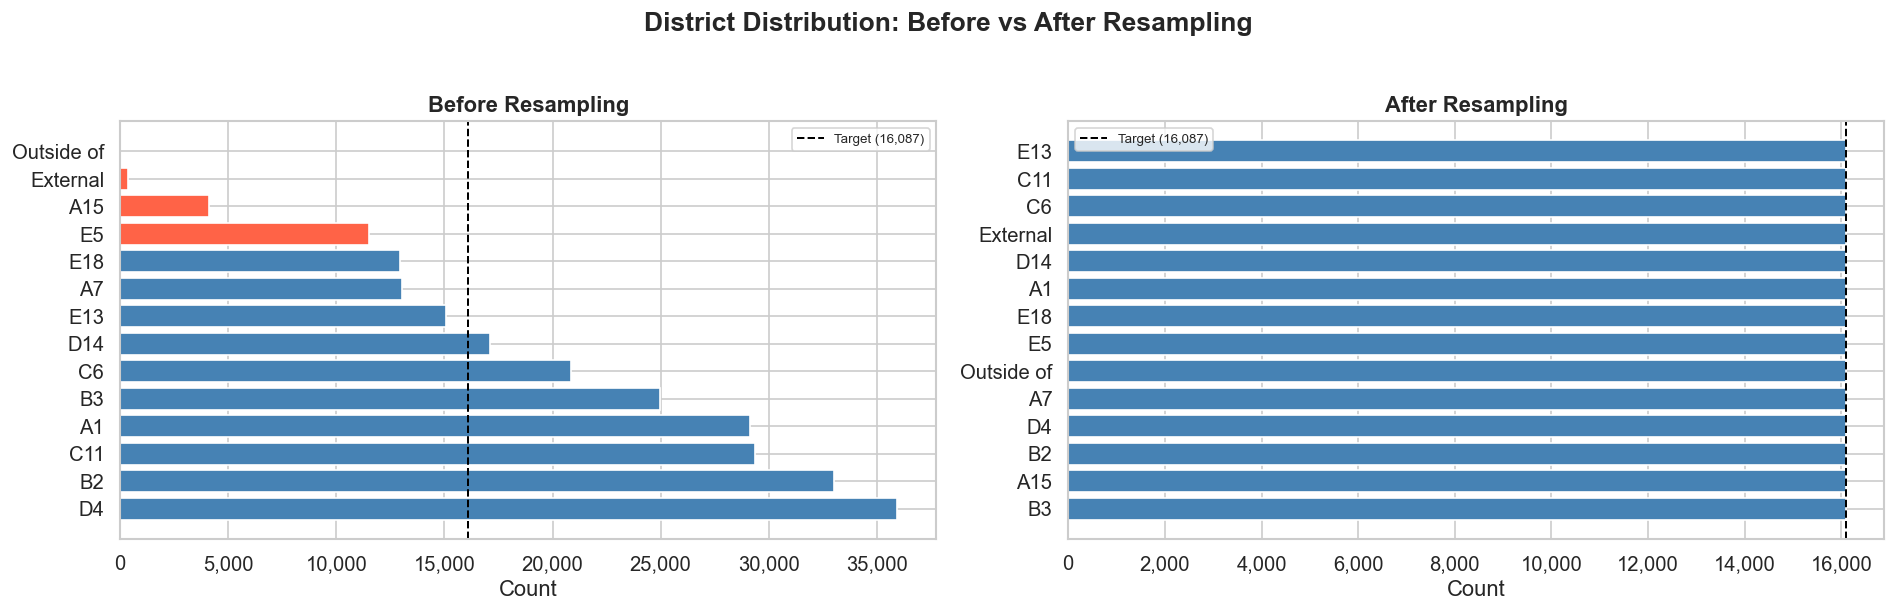

In [37]:
if "DISTRICT" in df.columns:
    district_counts = df["DISTRICT"].value_counts(dropna=True)
    target = int(district_counts.median())  # bring each district up to the median count
    print(f"Target (median) count per district: {target:,}")

    resampled_parts = []
    for district, grp in df.groupby("DISTRICT", dropna=True):
        n = len(grp)
        if n < target:
            # Oversample with replacement to reach the target
            extra = grp.sample(target - n, replace=True, random_state=42)
            resampled_parts.append(pd.concat([grp, extra], ignore_index=True))
        else:
            # Downsample to target to prevent dominant districts from overwhelming
            resampled_parts.append(grp.sample(target, replace=False, random_state=42))

    df_resampled = pd.concat(resampled_parts, ignore_index=True).sample(frac=1, random_state=42)
    print(f"\nResampled dataset shape: {df_resampled.shape}")

    # Compare before / after
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    for ax, data, title in [
        (axes[0], df, "Before Resampling"),
        (axes[1], df_resampled, "After Resampling"),
    ]:
        vc = data["DISTRICT"].value_counts()
        ax.barh(vc.index.astype(str), vc.values,
                color=["tomato" if v < target * 0.8 else "steelblue" for v in vc.values])
        ax.axvline(target, color="black", linestyle="--", linewidth=1.2, label=f"Target ({target:,})")
        ax.set_title(title, fontweight="bold")
        ax.set_xlabel("Count")
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
        ax.legend(fontsize=8)

    plt.suptitle("District Distribution: Before vs After Resampling", fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("DISTRICT column not found — skipping re-sampling.")

### 4.2 Threshold-based Flagging (High-Risk Districts by Shooting Rate)

Overall shooting rate : 0.0069
Flagging threshold    : 0.0138 (2× overall)

Flagged districts (1):


,shooting_rate
DISTRICT,
B3,0.016586


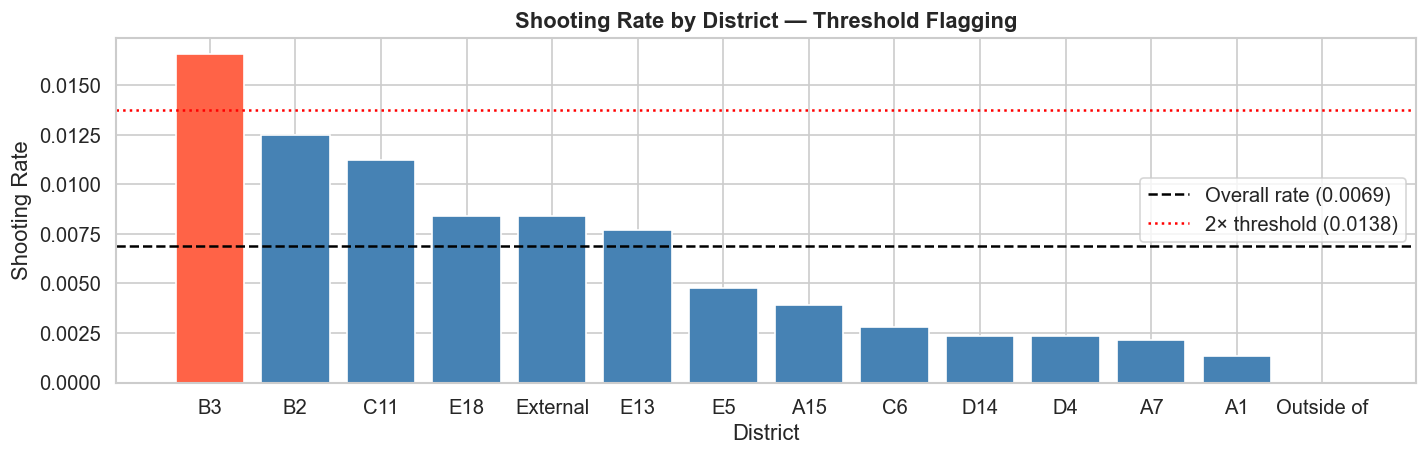

In [40]:
if {"DISTRICT", "SHOOTING"}.issubset(df.columns):
    df_th = df.dropna(subset=["DISTRICT", "SHOOTING"]).copy()
    df_th["SHOOTING_BIN"] = pd.to_numeric(df_th["SHOOTING"], errors="coerce").fillna(0).astype(int)
    #  ↑ SHOOTING is already 0/1 — just cast it cleanly, no string parsing needed

    shooting_by_district = df_th.groupby("DISTRICT")["SHOOTING_BIN"].mean().sort_values(ascending=False)
    overall_rate = df_th["SHOOTING_BIN"].mean()
    threshold    = 2.0 * overall_rate

    flagged = shooting_by_district[shooting_by_district >= threshold]
    print(f"Overall shooting rate : {overall_rate:.4f}")
    print(f"Flagging threshold    : {threshold:.4f} (2× overall)")
    print(f"\nFlagged districts ({len(flagged)}):")
    display(flagged.rename("shooting_rate").to_frame())

    fig, ax = plt.subplots(figsize=(12, 4))
    colors = ["tomato" if r >= threshold else "steelblue" for r in shooting_by_district.values]
    ax.bar(shooting_by_district.index, shooting_by_district.values, color=colors, edgecolor="white")
    ax.axhline(overall_rate, color="black", linestyle="--", label=f"Overall rate ({overall_rate:.4f})")
    ax.axhline(threshold,    color="red",   linestyle=":",  label=f"2× threshold ({threshold:.4f})")
    ax.set_title("Shooting Rate by District — Threshold Flagging", fontweight="bold")
    ax.set_ylabel("Shooting Rate")
    ax.set_xlabel("District")
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Required columns (DISTRICT, SHOOTING) not found.")

---
## 5 · Bias Detection & Mitigation — Summary

### Types of Bias Identified

| Bias Type | Description | Detected In |
|---|---|---|
| **Representational Bias** | Certain districts have far more / fewer records than others, suggesting uneven patrol coverage or selective reporting. | `DISTRICT` slice imbalance chart |
| **Reporting / Missingness Bias** | Missing rates for key fields (coordinates, SHOOTING) differ significantly by district. Incidents in some areas have systematically less detail. | Missing-value-by-district heatmap |
| **Temporal Bias** | Crime count peaks in mid-day/afternoon shifts and in summer months, which may reflect policing patterns rather than true crime rates. | Hour / Month bar charts |
| **Severity Imbalance** | UCR Part 1 (serious crimes) are heavily outnumbered by Part 2/3, creating class imbalance that can skew predictive models. | UCR_PART distribution |

### Mitigation Steps Taken

1. **Re-sampling (District)** — Underrepresented districts were oversampled (with replacement) and dominant districts were downsampled to the median district count. This ensures models trained on `df_resampled` see equal geographic representation.
2. **Threshold Flagging (Shooting Rate)** — Districts with shooting rates ≥ 2× the overall average are flagged for closer inspection. This guides where additional data collection or stricter review of model outputs should be prioritised.

### Trade-offs

| Trade-off | Description |
|---|---|
| **Accuracy ↔ Fairness** | Oversampling small districts adds synthetic data, which may slightly reduce the model's ability to replicate Boston-wide incident rates precisely. |
| **Recall ↔ Precision** | Lowering a decision threshold for high-shooting districts increases recall (catching more violent incidents) at the cost of more false positives. |
| **Data size** | Resampling changes total dataset size; downstream experiments should note which dataset (`df` or `df_resampled`) was used. |

> **Next steps:** Apply `df_resampled` when training predictive models. Re-evaluate model metrics (precision, recall, F1) using Fairlearn's `MetricFrame` on the held-out test set to ensure bias has been adequately reduced.
